## Hydrogen Wavefunctions & Electron Density Plots

Modeling and visualization of bound-state hydrogen eigenfunctions and electron probability densities.

- Author: Sebastian Mag
- Date: August 2025
- [Project Repository: https://github.com/ssebastianmag/hydrogen-wavefunctions](https://github.com/ssebastianmag/hydrogen-wavefunctions)

<hr>

**Model computations**

- Normalized radial functions with stable log-gamma normalization & complex spherical harmonics.
- Stationary-state wavefunction on an $x–z$ plane grid $(y=0)$.
- Probability densities and radial probability distributions.
- Reduced-mass Bohr radius and electron–nucleus reduced mass.

**Model assumptions:**

- Non-relativistic, point nucleus, Schrödinger hydrogenic Hamiltonian with Coulomb potential.
- No spin/fine-structure, external fields, or finite-nuclear-size effects.
- Shapes broadcast; $R$ is real-valued, $Y_{\ell}^{m}$ and $\psi$ are complex.
- $R$ and $\psi$ have units of $\,\mathrm{m}^{-3/2}$.
- $Y_{\ell}^{m}$ and $Z$ are dimensionless. 
- Cartesian coordinates $(x,y,z)$ and radial distance $r$ are in meters.
- Masses are in kilograms.

<hr>

### Dependencies & Libraries

In [1]:
from datetime import datetime
from typing import Optional, Literal
from pydantic import BaseModel

import numpy as np
import scipy.special as sp
from scipy.constants import physical_constants, m_e, m_p

from matplotlib import patheffects, ticker, colors
import matplotlib.pyplot as plt
import seaborn as sns

<hr>

### Reduced-mass correction and effective Bohr radius


To account for the finite nuclear mass, the model uses the electron–nucleus reduced mass $\mu$ and the corresponding reduced-mass Bohr radius $a_{\mu}$

$\large \mu = \frac{m_e M}{m_e + M}, \qquad a_{\mu} = a_0 \frac{m_e}{\mu}$

Here $m_e$ is the electron mass, $M$ is the nuclear mass (for Hydrogen $M \approx m_p$), and $a_0$ is the Bohr radius.

Setting $a_{\mu}\!\to\! a_0$ recovers the infinite–nuclear–mass approximation.


In [2]:
def reduced_electron_nucleus_mass(Z: int, M: Optional[float] = None):
    """ Compute electron–nucleus reduced mass μ.

        Parameters:
            Z (int): Nuclear charge number. (Z=1 for Hydrogen, Z>1 for hydrogenic ions).
            M (float): Nuclear mass in kg.

        Returns:
            float: Two-body (electron + nucleus) system reduced mass μ in kilograms.

        Notes:
            - If Z>1, M must be provided.
            - If Z=1 and M is not provided, proton mass m_p is assumed.
    """
    if M is None:
        if Z == 1:
            M = m_p
        else:
            raise ValueError("'M' must be provided if Z>1")

    return (m_e * M) / (m_e + M)


def reduced_bohr_radius(mu: float):
    """ Compute Bohr radius evaluated with a reduced mass.

        Parameters:
            mu (float): Electron–nucleus reduced mass μ in kg.

        Returns:
            float: Reduced-mass Bohr radius a_μ in meters.
    """
    a0 = physical_constants["Bohr radius"][0]
    return a0 * (m_e / mu)


<hr>

### Radial Component

$\large R_{n \ell}(r) = \left(\frac{2Z}{n a_{\mu}}\right)^{\!3/2}
\sqrt{\frac{(n-\ell-1)!}{2n(n+\ell)!}}\;
e^{-\frac{Z r}{n a_{\mu}}}
\left(\frac{2 Z r}{n a_{\mu}}\right)^{\ell}
L_{n-\ell-1}^{\,2\ell+1}\!\left(\frac{2 Z r}{n a_{\mu}}\right)$

The radial wavefunction gives us information about the probability
distribution of the electron as a function of distance $r$ from the 
nucleus.

In [3]:
def radial_wavefunction_Rnl(
        n: int,
        l: int,
        r: np.ndarray,
        Z: int = 1,
        use_reduced_mass: bool = True,
        M: Optional[float] = None
):
    """ Normalized hydrogenic radial wavefunction R_{n,l}(r).

        Parameters:
            n (int): Principal quantum number (n ≥ 1).
            l (int): Orbital angular-momentum quantum number (0 ≤ l ≤ n-1).
            r (np.ndarray): Radial coordinate(s) in meters.
            Z (int): Nuclear charge number. (Z=1 for Hydrogen, Z>1 for hydrogenic ions).
            use_reduced_mass (bool): Reduced-mass μ correction in Bohr radius.
            M (float): Nuclear mass in kg.

        Returns:
            R (np.ndarray): Real-valued radial eigenfunction samples with broadcasted shape of (r).

        Notes:
            - R has units of m^{-3/2}.
            - If use_reduced_mass = True, evaluate the Bohr radius with an electron–nucleus reduced mass μ,
              otherwise, use invariant electron mass m_e (μ = m_e ∴ a_μ = a₀) in the infinite–mass approximation.
            - If Z>1 and use_reduced_mass = True, M must be provided.
            - If Z=1 and M is not provided, proton mass m_p is assumed.
    """
    if not (n >= 1 and 0 <= l <= n - 1):
        raise ValueError("(!) Quantum numbers (n,l) must satisfy n ≥ 1 and 0 ≤ l ≤ n-1")

    mu = reduced_electron_nucleus_mass(Z, M) if use_reduced_mass else m_e
    a_mu = reduced_bohr_radius(mu)

    rho = 2.0 * Z * r / (n * a_mu)
    L = sp.eval_genlaguerre(n - l - 1, 2 * l + 1, rho)

    # Stable normalization prefactor using log-gamma
    # pref = (2Z/(n a_mu))^(3/2) * sqrt( (n-l-1)! / (2n * (n+l)!))

    log_pref = 1.5 * np.log(2.0 * Z / (n * a_mu))
    log_pref += 0.5 * (sp.gammaln(n - l) - (np.log(2.0 * n) + sp.gammaln(n + l + 1)))
    pref = np.exp(log_pref)
    R = pref * np.exp(-rho / 2.0) * np.power(rho, l) * L
    return R


<hr>

### Angular Component

$\large Y_{\ell}^{m}(\theta, \phi) = (-1)^m \sqrt{\frac{(2\ell+1)}{4\pi}\frac{(\ell-m)!}{(\ell+m)!}}\, P_{\ell}^{m}(\cos\theta)\, e^{i m \phi}$

The angular wavefunction yields the spherical harmonics, which gives the angular dependence of the wavefunction in terms of the polar ($\theta$) and azimuthal ($\phi$) angles.

In [4]:
def spherical_harmonic_Ylm(
        l: int,
        m: int,
        theta: np.ndarray,
        phi: np.ndarray
):
    """ Complex spherical harmonic Y_{l,m}(theta,phi); orthonormal on S².

        Parameters:
            l (int): Orbital angular-momentum quantum number (l ≥ 0).
            m (int): Magnetic quantum number (-l ≤ m ≤ l).
            theta (np.ndarray): Polar angle(s) in radians in the interval theta ∈ [0, π].
            phi (np.ndarray): Azimuthal angle(s) in radians in the interval phi ∈ [0, 2π).

        Returns:
            Y (np.ndarray): Complex-valued spherical harmonic with broadcasted shape of (theta, phi).
    """
    if not (l >= 0 and -l <= m <= l):
        raise ValueError("(!) Quantum numbers (l,m) must satisfy l ≥ 0 and -l ≤ m ≤ l")

    theta = np.asarray(theta, dtype=float)
    phi = np.asarray(phi, dtype=float)
    Y = sp.sph_harm_y(l, m, theta, phi)
    return Y


<hr>

### Normalized Wavefunction

The resultant normalized wavefunction for the hydrogen atom (and hydrogenic ions) is the product of the solutions of the radial and angular components:

$\large \psi_{n \ell m}(r, \theta, \phi) = R_{n \ell}(r)\; Y_{\ell}^{m}(\theta, \phi)$

In [5]:
def compute_psi_xz_slice(
    n: int,
    l: int,
    m: int,
    Z: int = 1,
    use_reduced_mass: bool = True,
    M: Optional[float] = None,
    extent_a_mu: float = 20.0,
    grid_points: int = 600,
    phi_value: float = 0.0,
    phi_mode: Literal["plane", "constant"] = "plane"
):
    """ Evaluate psi_{n,l,m}(x,0,z), hydrogenic eigenfunction restricted to the y=0 (x–z) plane.

        Parameters:
            n (int): Principal quantum number (n ≥ 1).
            l (int): Orbital angular-momentum quantum number (0 ≤ l ≤ n-1).
            m (int): Magnetic quantum number (-l ≤ m ≤ l).
            Z (int): Nuclear charge number. (Z=1 for Hydrogen, Z>1 for hydrogenic ions).
            use_reduced_mass (bool): Reduced-mass μ correction in Bohr radius.
            M (float): Nuclear mass in kg.
            extent_a_mu (float): Half-width of the square grid in units of the reduced-mass Bohr radius.
            grid_points (int): Number of points per Cartesian axis.
            phi_value (float): Azimuth phi (radians); Only used if phi_mode="constant".
            phi_mode (str): Azimuthal prescription on y=0.

        Returns:
            Xg (np.ndarray): 2D Cartesian x-coordinate grid (y=0) in meters.
            Zg (np.ndarray): 2D Cartesian z-coordinate grid (y=0) in meters.
            psi (np.ndarray): Complex-valued coordinate-space wavefunction samples psi(x,z) on y=0.
            a_mu (float): Reduced-mass Bohr radius a_μ in meters.

        Notes:
            - psi has units of m^{-3/2}.
            - If use_reduced_mass = True, evaluate the Bohr radius with an electron–nucleus reduced mass μ,
              otherwise, use invariant electron mass m_e (μ = m_e ∴ a_μ = a₀) in the infinite–mass approximation.
            - If Z>1 and use_reduced_mass = True, M must be provided.
            - If Z=1 and M is not provided, proton mass m_p is assumed.
            - Xg, Zg and psi have the shape (grid_points, grid_points).
            - If phi_mode = "plane", phi=0 for x ≥ 0, phi = π for x < 0.
            - If phi_mode = "constant", phi ≡ phi_value across the grid.
    """
    if not (n >= 1 and 0 <= l <= n - 1 and -l <= m <= l):
        raise ValueError("(!) Quantum numbers (n,l,m) must satisfy n ≥ 1, 0 ≤ l ≤ n-1, and -l ≤ m ≤ l")

    mu = reduced_electron_nucleus_mass(Z, M) if use_reduced_mass else m_e
    a_mu = reduced_bohr_radius(mu)

    r_max = extent_a_mu * a_mu
    axis = np.linspace(-r_max, r_max, grid_points)
    Zg, Xg = np.meshgrid(axis, axis, indexing="ij")

    r = np.hypot(Xg, Zg)
    cos_theta = np.empty_like(r)
    np.divide(Zg, r, out=cos_theta, where=(r > 0))
    cos_theta[r == 0] = 1.0

    theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    phi = np.where(Xg >= 0.0, 0.0, np.pi) if phi_mode == "plane" else np.full_like(r, float(phi_value))

    # Compute psi_{n,l,m}(r,theta,phi) = R_{n,l}(r) · Y_{l,m}(theta,phi)
    R = radial_wavefunction_Rnl(n, l, r, Z=Z, use_reduced_mass=use_reduced_mass, M=M)
    Y = spherical_harmonic_Ylm(l, m, theta, phi)
    psi = R * Y

    return Xg, Zg, psi, a_mu


<hr>

To determine the probability density $|\psi_{n \ell m}|^2$ of the electron being in a certain location,
we take the square magnitude of the wavefunction:

$\large P(r, \theta, \phi) = |\psi_{n \ell m}(r, \theta, \phi)|^2$

In [6]:
def compute_probability_density(psi: np.ndarray):
    """ Retrieve probability density |psi|^2.

        Parameters:
            psi (np.ndarray): Complex-valued coordinate-space wavefunction samples psi(x,z) on y=0.

        Returns:
            P (np.ndarray): Real-valued |psi|^2 with the same shape as psi.
    """
    return np.abs(psi) ** 2


In addition, the radial probability distribution describes the probability of finding the electron between $r$ and $r+dr$:

$\large P_{n\ell}(r) = r^2\, |R_{n\ell}(r)|^2$


In [7]:
def compute_radial_probability_distribution(R: np.ndarray, r: np.ndarray):
    """ Retrieve Radial probability distribution P_{n,l}(r) = r^2 * |R_{n,l}(r)|^2.

        Parameters:
            R (np.ndarray): Real-valued radial eigenfunction samples R_{n,l}(r).
            r (np.ndarray): Radial coordinate(s) in meters.

        Returns:
            P_r (np.ndarray): Real-valued P_{n,l}(r) with the same shape as r.
    """
    return (r**2) * np.abs(R) ** 2


<hr>

### 2D electron probability density $|\psi|^2$ plot

For visualization, the model evaluates stationary states on the plane $y=0$:

$\large \psi_{n\ell m}(x,0,z) = R_{n\ell}(r)\, Y_{\ell}^{m}(\theta,\phi), \quad r=\sqrt{x^2+z^2}, \quad \cos\theta=\frac{z}{r}$

In [8]:
class WaveFunction(BaseModel):
    """ Wavefunction schema.
        [Composite of 'hydrogen_wavefunction.compute_psi_xz_slice'].
    """
    n: int
    l: int
    m: int
    Z: int = 1
    use_reduced_mass: bool = True
    M: Optional[float] = None
    extent_a_mu: float = 20.0
    grid_points: int = 600
    phi_value: float = 0.0
    phi_mode: Literal["plane", "constant"] = "plane"


def plot_hydrogen_wavefunction_xz(
        wf: WaveFunction,
        colormap: str = "rocket",
        use_dark_theme: bool = False,
        k: Optional[float] = None,
        exposure: Optional[float] = 0.0
):
    """ Plot hydrogen wavefunction restricted to the y=0 (x–z) plane.

        Parameters:
            wf (WaveFunction): Wavefunction parameters.
            colormap (str): Seaborn colormap name.
            use_dark_theme (bool): Plot theme rendering mode.
            k (float): Framing scale factor for extent calculation.
            exposure (float): Exposure correction factor for low-probability regions.
    """
    try:
        _ = sns.color_palette(colormap)
    except Exception:
        raise ValueError(f"(!) {colormap!r} is not a recognized Seaborn colormap.")

    if k is not None:  # Compute extent from framing scale factor (if provided)
        wf.extent_a_mu = float(k * (3 * wf.n * wf.n - wf.l * (wf.l + 1)) / (2 * wf.Z))

    # Retrieve X-Z grid, psi, reduced Bohr radius and P = |psi|^2
    Xg, Zg, psi, a_mu = compute_psi_xz_slice(
        n=wf.n, l=wf.l, m=wf.m, Z=wf.Z,
        use_reduced_mass=wf.use_reduced_mass,
        M=wf.M,
        extent_a_mu=wf.extent_a_mu,
        grid_points=wf.grid_points,
        phi_value=wf.phi_value,
        phi_mode=wf.phi_mode,
    )

    P = compute_probability_density(psi)

    # Global styles
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["mathtext.fontset"] = "stix"

    plt.rcParams["xtick.major.width"] = 4
    plt.rcParams["ytick.major.width"] = 4

    plt.rcParams["xtick.major.size"] = 15
    plt.rcParams["ytick.major.size"] = 15

    plt.rcParams["xtick.labelsize"] = 30
    plt.rcParams["ytick.labelsize"] = 30
    plt.rcParams["axes.linewidth"] = 4

    fig, ax = plt.subplots(figsize=(17, 16.5))
    plt.subplots_adjust(top=0.82, right=0.87, left=-0.10)

    # Theme styles
    if use_dark_theme:

        # Background color -> Darkest color in the colormap
        pal_100 = sns.color_palette(colormap, n_colors=100)
        background_color = sorted(pal_100, key=lambda c: 0.2126 * c[0] + 0.7152 * c[1] + 0.0722 * c[2])[0]

        title_color = text_color = "#dfdfdf"
        tick_color = "#c4c4c4"

        fig.patch.set_facecolor(background_color)
        for spine in ax.spines.values():
            spine.set_color(tick_color)

        ax.tick_params(axis="x", colors=tick_color)
        ax.tick_params(axis="y", colors=tick_color)

    else:
        title_color = text_color = tick_color = "#000000"
        ax.tick_params(axis="x", colors=tick_color)
        ax.tick_params(axis="y", colors=tick_color)

    cmap = sns.color_palette(colormap, as_cmap=True)

    # Render plot within bounds scaled by reduced Bohr radius
    extent: tuple[float, float, float, float] = (
        float(np.min(Xg) / a_mu),
        float(np.max(Xg) / a_mu),
        float(np.min(Zg) / a_mu),
        float(np.max(Zg) / a_mu),
    )

    # Apply exposure correction (if provided)
    # Higher exposure -> Increase visibility in low-probability regions

    finite = P[np.isfinite(P)]
    vmin, vmax = 0.0, (float(np.percentile(finite, 99.9)) if finite.size else 1.0)
    vmax = float(finite.max()) if (finite.size and (not np.isfinite(vmax) or vmax <= vmin)) else vmax

    exp = max(0.0, float(exposure))
    gamma = max(0.10, 1.0 / (1.0 + exp))

    norm_linear = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    norm_exposed = colors.PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax, clip=True)
    norm = norm_exposed if exp > 0.0 else norm_linear

    im = ax.imshow(P, extent=extent, origin="lower", aspect="equal", cmap=cmap, norm=norm)

    # Axis labels
    x_z_units = r"a_\mu" if wf.use_reduced_mass else r"a_0"
    ax.set_xlabel(rf"$x / {x_z_units}$", fontsize=43, color=text_color)
    ax.set_ylabel(rf"$z / {x_z_units}$", fontsize=45, color=text_color)
    ax.xaxis.set_label_coords(x=0.5, y=-0.075)
    ax.yaxis.set_label_coords(x=-0.08, y=0.5)

    # Title and subtitle
    ax.set_title(
        "Hydrogen Wavefunction - Probability Density",
        pad=130, fontsize=44, loc="left", color=title_color
    )

    fig.text(
        x=ax.get_position().x0 + 0.07, y=0.868,
        s=r"$|\psi_{n\ell m}(r,\theta,\phi)|^{2} = |R_{n\ell}(r) Y_{\ell}^{m}(\theta,\phi)|^2$",
        fontsize=40, color=title_color
    )

    # Colormap colorbar
    cbar = plt.colorbar(im, fraction=0.046, pad=0.025)
    cbar.set_label(r"Probability density $|\psi|^{2}$ [m$^{-3}$]", fontsize=40, color=text_color, labelpad=34)
    cbar.ax.tick_params(labelsize=26, colors=text_color)
    cbar.ax.set_frame_on(not use_dark_theme)

    sf = ticker.ScalarFormatter(useMathText=True)
    sf.set_powerlimits((0, 0))
    cbar.formatter = sf
    cbar.update_ticks()

    fig.canvas.draw()
    off = cbar.ax.yaxis.get_offset_text()
    offset_str = off.get_text()
    off.set_visible(False)
    cbar.ax.text(
        0.7, 1.02, offset_str,
        transform=cbar.ax.transAxes, ha="center", va="bottom",
        fontsize=28, color=text_color
    )

    # Quantum numbers (n,l,m) label
    h, w = P.shape
    patch = P[max(h - 40, 0):h, 0:min(40, w)]  # Sample top-left corner patch to gauge brightness
    patch_val = np.nanmean(P) if patch.size == 0 else float(np.nanmean(patch))

    r, g, b, _ = im.cmap(im.norm(patch_val))  # Compute luminance of patch color
    luminance = 0.2126 * r + 0.7152 * g + 0.0722 * b
    qn_color = "#ffffff" if luminance < 0.5 else "#000000"
    qn_outline = "#000000" if qn_color == "#ffffff" else "#ffffff"

    ax.text(
        x=0.04, y=0.95, s=f"({wf.n}, {wf.l}, {wf.m})",
        transform=ax.transAxes, ha="left", va="top",
        fontsize=42, color=qn_color,
        path_effects=[patheffects.withStroke(linewidth=3.0, foreground=qn_outline)]
    )

    # Save and display figure
    ts = datetime.now().strftime("%Y%m%d%H%M%S")
    filename = f"({wf.n},{wf.l},{wf.m})_{ts}"
    plt.savefig(filename)
    plt.show()


<hr>

### Modeling Examples

In [9]:
# Set Notebook figure/plot size
plt.rcParams["figure.dpi"] = 36

Below there are some example plots generated for various quantum states of the hydrogen atom.

$\large n=3, \ell=2, m=1, Z=1$

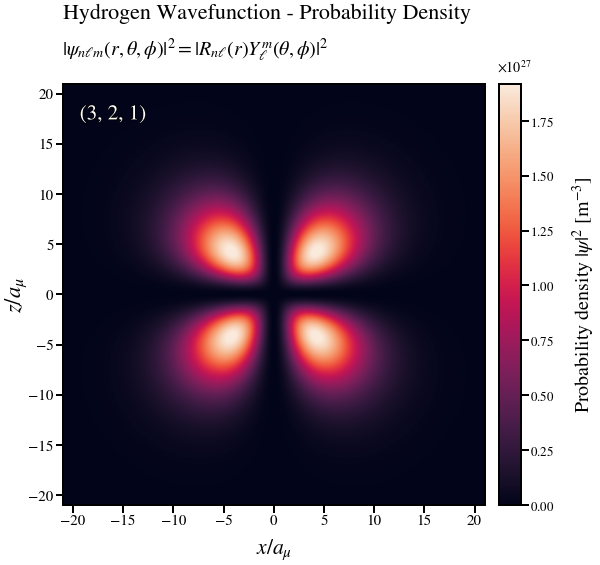

In [10]:
wf = WaveFunction(n=3, l=2, m=1)
plot_hydrogen_wavefunction_xz(wf, colormap="rocket", k=2)

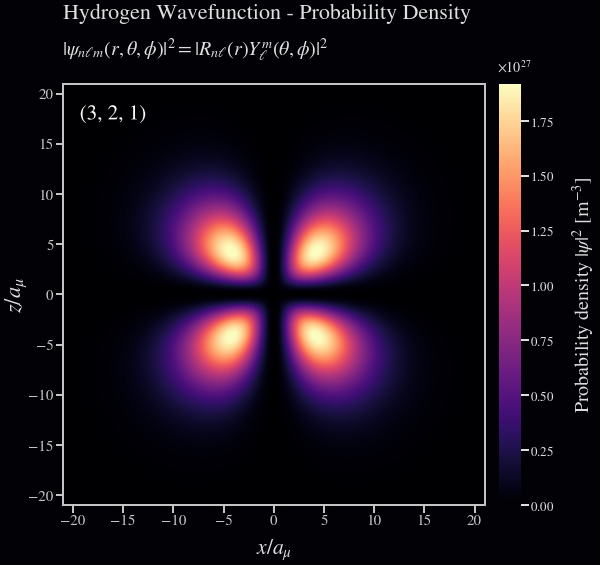

In [11]:
plot_hydrogen_wavefunction_xz(wf, colormap="magma", use_dark_theme=True, k=2)

<hr>

$\large n=4, \ell=3, m=0, Z=1$

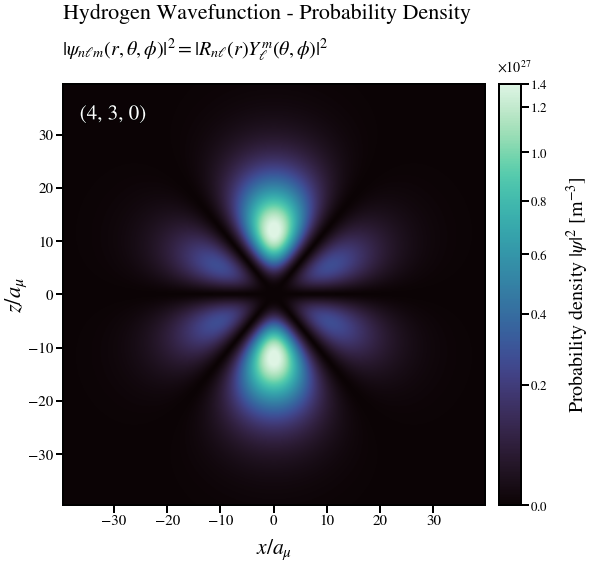

In [12]:
wf = WaveFunction(n=4, l=3, m=0)
plot_hydrogen_wavefunction_xz(wf, colormap="mako", k=2.2, exposure=0.5)

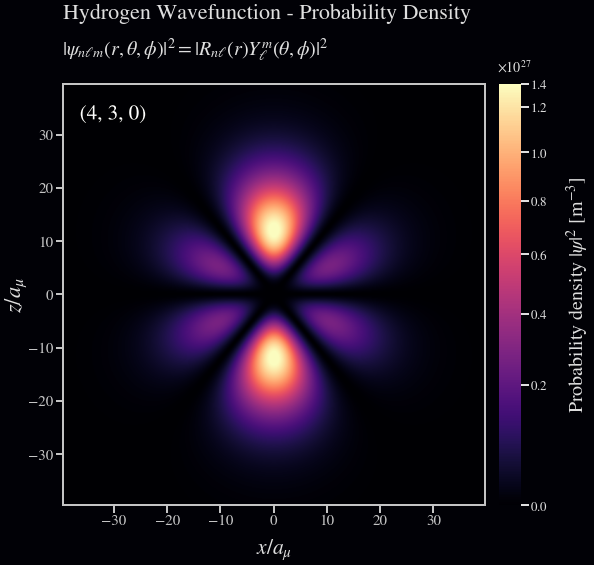

In [13]:
plot_hydrogen_wavefunction_xz(wf, colormap="magma", use_dark_theme=True, k=2.2, exposure=0.5)

<hr>

$\large n=3, \ell=0, m=0, Z=1$

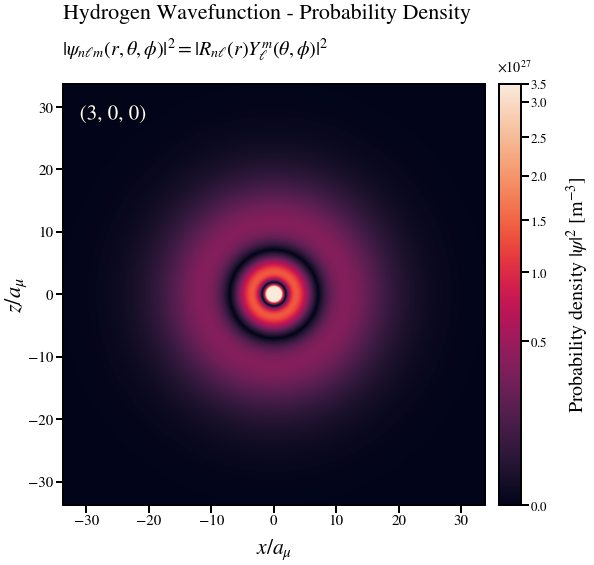

In [14]:
wf = WaveFunction(n=3, l=0, m=0)
plot_hydrogen_wavefunction_xz(wf, colormap="rocket", k=2.5, exposure=1)

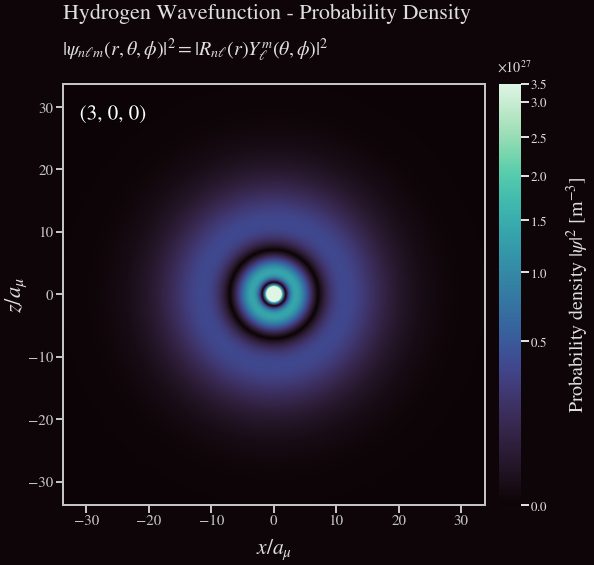

In [15]:
plot_hydrogen_wavefunction_xz(wf, colormap="mako", use_dark_theme=True, k=2.5, exposure=1)

<hr>

$\large n=4, \ell=3, m=1, Z=1$

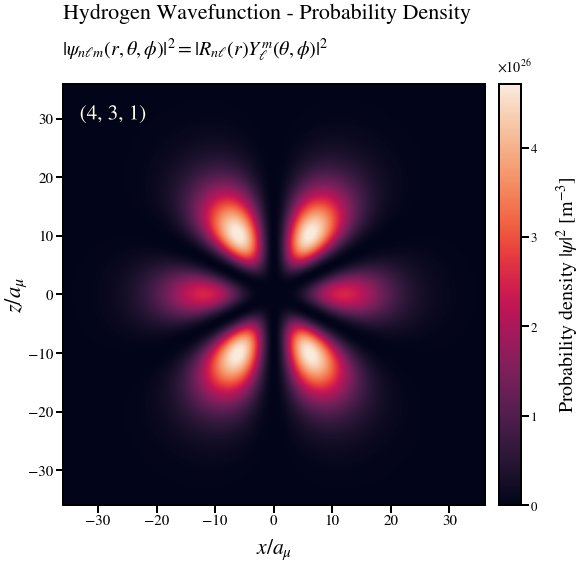

In [16]:
wf = WaveFunction(n=4, l=3, m=1)
plot_hydrogen_wavefunction_xz(wf, colormap="rocket", k=2)

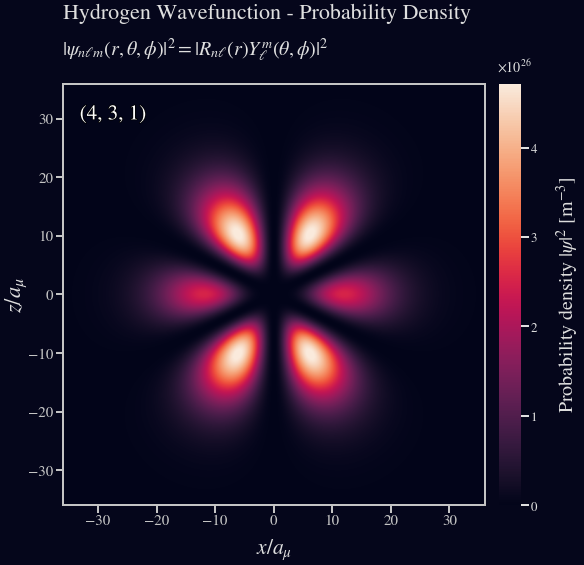

In [17]:
plot_hydrogen_wavefunction_xz(wf, colormap="rocket", use_dark_theme=True, k=2)

<hr>

$\large n=32, \ell=16, m=1, Z=1$

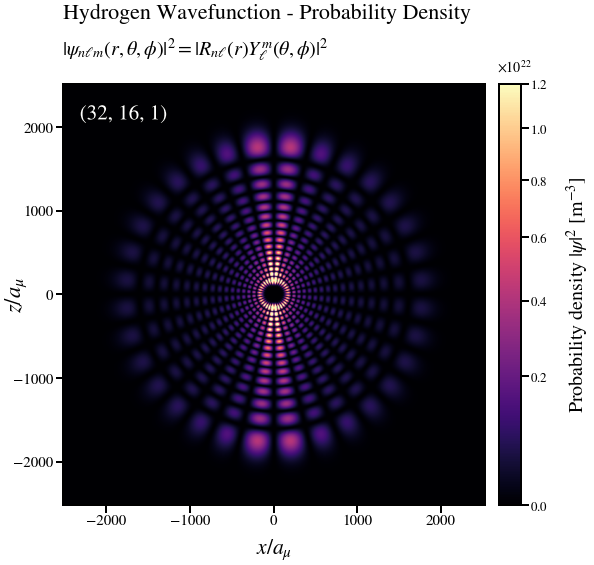

In [18]:
wf = WaveFunction(n=32, l=16, m=1)
plot_hydrogen_wavefunction_xz(wf, colormap="magma", k=1.8, exposure=0.5)

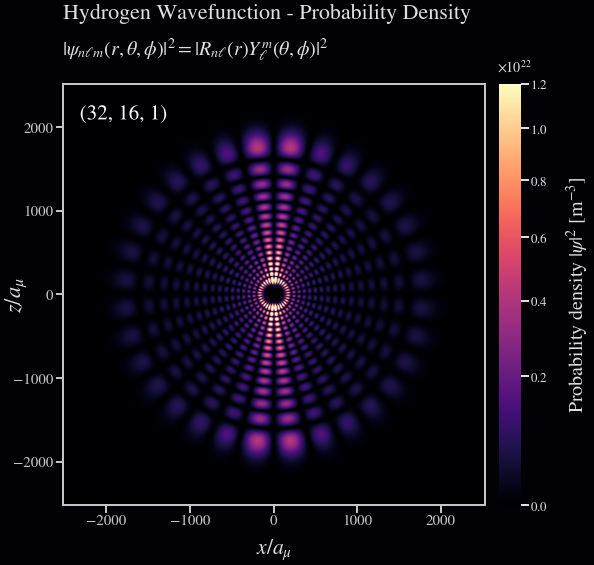

In [19]:
plot_hydrogen_wavefunction_xz(wf, colormap="magma", use_dark_theme=True, k=1.8, exposure=0.5)

As we examine the electron density plots corresponding to the quantum numbers above, we notice that with increasing principal quantum number $n$ , the complexity of the wavefunction grows. Specifically:

- The number of nodes (regions where the probability density is zero) increases.
- The electron's spatial distribution expands, covering larger regions around the nucleus.
- The overall shape of the atomic orbital becomes more intricate and detailed.

<hr>

### References

- Griffiths, D.J. (2016) Introduction to quantum mechanics. 3rd edn. Harlow: Pearson. 
- Atkins, P. and Friedman, R. (2011) Molecular quantum mechanics. 5th edn. Oxford: Oxford University Press. 
- Bransden, B.H. and Joachain, C.J. (2003) Quantum mechanics. 2nd edn. Harlow: Pearson Education. 
- Zettili, N. (2009) Quantum mechanics: concepts and applications. 2nd edn. Chichester: Wiley. 
- Eisberg, R. and Resnick, R. (1985) Quantum physics of atoms, molecules, solids, nuclei, and particles. 2nd edn. New York: Wiley.
- Bethe, H.A. & Salpeter, E.E. (1957) Quantum Mechanics of One- and Two-Electron Atoms. Berlin: Springer.
- Landau, L.D. & Lifshitz, E.M. (1977) Quantum Mechanics: Non-Relativistic Theory. 3rd edn. Oxford: Pergamon.
- Edmonds, A.R. (1960) Angular Momentum in Quantum Mechanics. 2nd edn. Princeton, NJ: Princeton University Press.
- Freie Universität Berlin (2015) Theoretical chemistry, Available at: https://www.bcp.fu-berlin.de/en/chemie/chemie/forschung/PhysTheoChem/agkeller/_Docs/TC_WS15_Ex07.pdf
